Este projeto o trabalho de fim de curso do aluno Igor Peterossi Lopes (RA:174929) para o curso de engenharia elétrica da Unicamp, feito no 2 semestre de 2022.

Este trabalho pretende resolver um problema de classificação binária através de três estratégias distintas: com um classificador implementado com regressão logística, com uma máquina de vetores suporte e com redes neurais. Para que, através dos resultados obtidos, possamos comparar cada método de resolução do problema e identificar a sua eficácia.

O problema que esta sendo analisado é o da classificação de websites em sites de phishing e sites seguros (que não são de phishing), os dados para essa classificação fazem parte do acervo de machine learning da University of California, School of Information and Computer Science, disponível no seguinte link: https://archive.ics.uci.edu/ml/datasets/phishing+websites


In [1]:
# Configurações técnicas gerais para a realização do projeto

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

Como primeira etapa, obtemos os dados que serão estudados e depois passamos a fazer pequenas adaptações nestes a fim de viabilizar a sua utilização pelos modelos que serão desenvolvidos

In [2]:
from sklearn.datasets import fetch_openml

X_data, y_data = fetch_openml(data_id=4534, return_X_y=True)
X_data = X_data.astype("int64")
y_data = y_data.astype("int64")

def map_output(value):
    if value == -1:
        return 0
    return value

y_data = y_data.apply(map_output)

Agora realizamos algumas observações em cima dos dados para que possamos compreender melhor as suas características
Começamos unindo o dataset de features com o dos resultados, para facilitar nossas análises

In [3]:
complete_data = X_data.copy(deep=True)
complete_data["Result"] = y_data
complete_data.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,0
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,0
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,0
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,0
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


Observando como as nossas classes estão distribuídas (sites classificados como phishing x sites normais), notamos uma quantidade ligeiramente maior de casos "positivos", sites identificados como de phishing, em relação aos casos negativos (sites que não são de phishing), ainda sim o dataset é bem equilibrado

<AxesSubplot: xlabel='Values', ylabel='Websites'>

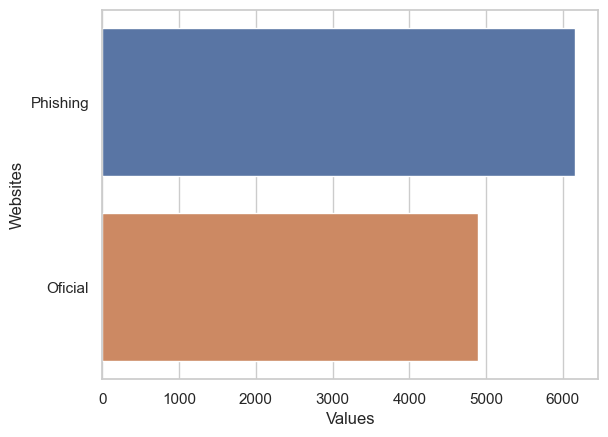

In [4]:
series = complete_data['Result'].value_counts()
total_classes = pd.DataFrame({'Websites': ['Phishing', 'Oficial'], 'Values': [series[1], series[0]]})
sns.barplot(x = 'Values', y = 'Websites', data = total_classes)

Analisamos também a correlação entre cada feature disponível no nosso dataset e a classificação entre phishing e oficial

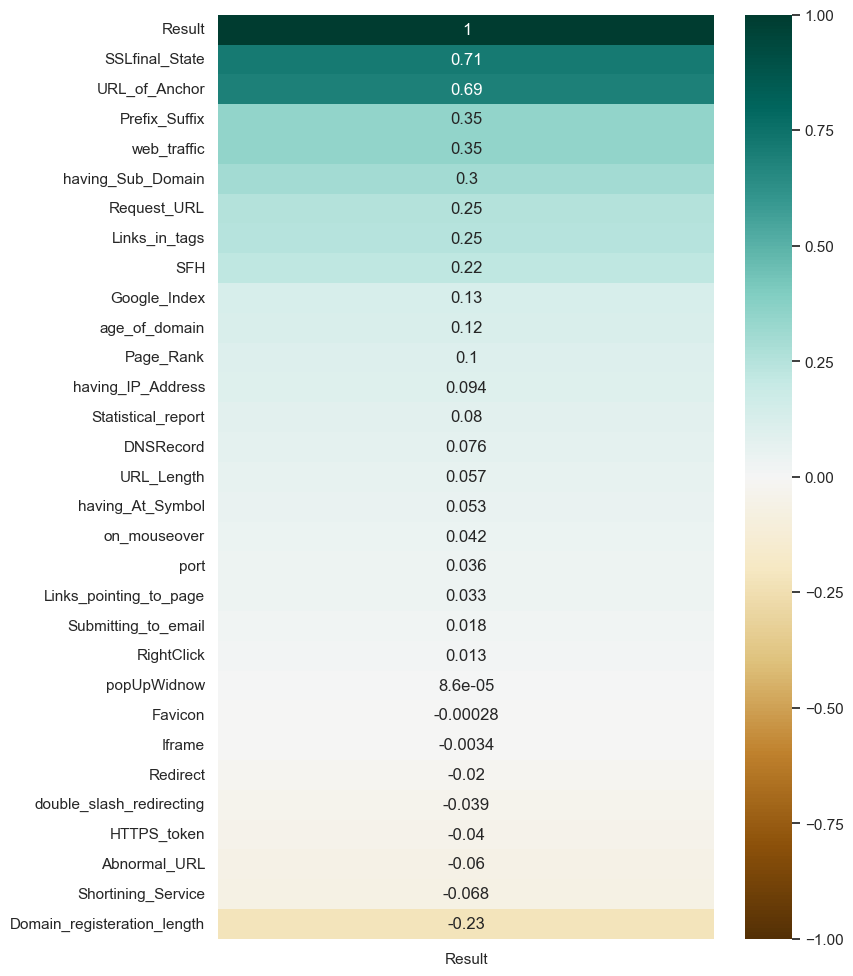

In [5]:
result_correlation_df = complete_data.corr()[['Result']].sort_values(by='Result', ascending=False)
plt.figure(figsize=(8, 12))
mask = np.triu(np.ones_like(result_correlation_df, dtype=bool))
heatmap = sns.heatmap(result_correlation_df, vmin=-1, vmax=1, annot=True, cmap='BrBG')

Com base nas informações de correlação acima, podemos simplificar o nosso dataset eliminando todas as features que apresentam correlação mínima como resultado, ou seja, que pouco influênciam na identificação de um site como de phishing

In [6]:
X_data = X_data.drop(columns=['having_IP_Address', 'Statistical_report', 'DNSRecord', 'URL_Length', 'having_At_Symbol', 'on_mouseover', 'port', 'Links_pointing_to_page', 'Submitting_to_email', 'RightClick', 'popUpWidnow', 'Favicon', 'Iframe', 'Redirect', 'double_slash_redirecting', 'HTTPS_token', 'Abnormal_URL', 'Shortining_Service'])

A nossa estratégia para execução do projeto será de treinar cada modelo utilizando 3 variações do dataset, primeiro utilizando o dataset original otimizado, depois com o dataset "piorado" ao se retirar as duas features mais impactam na classificação dos sites e, por fim, além de retirar estas 2 features, reduzimos o tamanho do dataset para apenas 1000 resultados.
Com os modelos treinados, determinaremos para cada um deles os f1-scores de treinamento e de teste e o overfiting (diferença entre os f1-scores de treinamento e de teste) e salvamos estas informações em uma tabela para realizarmos a comparação entre cada algoritmo utilizado, teremos 3 tabelas, uma para cada versão do dataset. Plotaremos também a matriz de confusão para cada método, como um parâmetro a mais para aprofundar nossa análise

In [7]:
orig_analysis_data = {}
wor_analysis_data = {}
wor2_analysis_data = {}

Usaremos as biblioteca scikit-learn e tensorflow para auxiliar no desenvolvimento dos modelos, e para a separação dos nossos dados em partes para treinamento e para validação posterior

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)

In [9]:
from sklearn.metrics import confusion_matrix, f1_score

def evaluate_algorithm(X_train, y_train, X_test, y_test, model, model_name, analysis_data):

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    f1_train = f1_score(y_train, y_train_pred, average='macro')
    f1_test = f1_score(y_test, y_test_pred, average='macro')

    overfitting = 100 * (1 - f1_test/f1_train)

    model_results = {'F1-Score Train': f1_train, 'F1-Score Test': f1_test, 'Overfitting': overfitting}

    analysis_data[model_name] = (model_results.values())

def evaluate_neural_network(X_train, y_train, X_test, y_test, model, model_name, analysis_data):

    y_train_pred = model.predict(X_train)
    y_train_pred = np.where(y_train_pred > 0.5, 1, 0)

    y_test_pred = model.predict(X_test)
    y_test_pred = np.where(y_test_pred > 0.5, 1, 0)

    f1_train = f1_score(y_train, y_train_pred, average='macro')
    f1_test = f1_score(y_test, y_test_pred, average='macro')

    overfitting = 100 * (1 - f1_test/f1_train)

    model_results = {'F1-Score Train': f1_train, 'F1-Score Test': f1_test, 'Overfitting': overfitting}

    analysis_data[model_name] = (model_results.values())

def create_confusion_matrix(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Criamos e treinamos cada um dos algoritmos de machine learning que avaliaremos neste projeto, e também determinamos os parâmetros que servirão de base para a comparação e avaliação da qualidade de cada método para resolver o problema

In [10]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense

# Logistic Regression Model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Support Vectors Model
svm = LinearSVC(C=0.0001)
svm.fit(X_train, y_train)

# 1 Neural Network Model
network1 = Sequential()
network1.add(Dense(12, activation='relu', input_shape=(X_data.shape[1],)))
network1.add(Dense(1, activation='sigmoid'))
network1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
network1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100, verbose=False)

# 2 Neural Network Model
network2 = Sequential()
network2.add(Dense(12, activation='relu', input_shape=(X_data.shape[1],)))
network2.add(Dense(6, activation='relu', input_shape=(X_data.shape[1],)))
network2.add(Dense(1, activation='sigmoid'))
network2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
network2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100, verbose=False)

2022-11-27 22:52:17.293099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 22:52:21.333125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
evaluate_algorithm(X_train, y_train, X_test, y_test, logreg, 'Regressão Logística', orig_analysis_data)
evaluate_algorithm(X_train, y_train, X_test, y_test, svm, 'Vetores Suporte', orig_analysis_data)
evaluate_neural_network(X_train, y_train, X_test, y_test, network1, 'Rede Neural 1', orig_analysis_data)
evaluate_neural_network(X_train, y_train, X_test, y_test, network2, 'Rede Neural 2', orig_analysis_data)

104/104 [==============================] - 0s 1ms/step


Com as estatísticas de cada algoritmo, montamos a tabela que consolida estes dados

In [12]:
orig_analysis_df = pd.DataFrame.from_dict(orig_analysis_data, orient='index')
orig_analysis_df.columns = ['F1-score Treinamento', 'F1-score Teste', 'Overfitting (%)']
orig_analysis_df

,F1-score Treinamento,F1-score Teste,Overfitting (%)
Regressão Logística,0.921897,0.917454,0.481904
Vetores Suporte,0.912080,0.907548,0.496837
Rede Neural 1,0.924493,0.918354,0.664034
Rede Neural 2,0.928330,0.928221,0.011815


Repetiremos este mesmo processo acima, agora com o nosso dataset piorado ao se eliminar as 2 melhores features para a classificação

In [13]:
X_data_edit = X_data.copy(deep=True)
y_data_edit = y_data.copy(deep=True)

# Drop das melhores features
X_data_edit = X_data_edit.drop(columns=['SSLfinal_State'])
X_data_edit = X_data_edit.drop(columns=['URL_of_Anchor'])

X_train_edit, X_test_edit, y_train_edit, y_test_edit = train_test_split(X_data_edit, y_data_edit, test_size=0.3, random_state=0)

In [14]:
# Logistic Regression Model
logreg.fit(X_train_edit, y_train_edit)

# Support Vectors Model
svm.fit(X_train_edit, y_train_edit)

# 1 Neural Network Model
network1_edit = Sequential()
network1_edit.add(Dense(10, activation='relu', input_shape=(X_data_edit.shape[1],)))
network1_edit.add(Dense(1, activation='sigmoid'))
network1_edit.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
network1_edit.fit(X_train_edit, y_train_edit, validation_data=(X_test_edit, y_test_edit), epochs=10, batch_size=100, verbose=False)

# 2 Neural Network Model
network2_edit = Sequential()
network2_edit.add(Dense(10, activation='relu', input_shape=(X_data_edit.shape[1],)))
network2_edit.add(Dense(5, activation='relu', input_shape=(X_data_edit.shape[1],)))
network2_edit.add(Dense(1, activation='sigmoid'))
network2_edit.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
network2_edit.fit(X_train_edit, y_train_edit, validation_data=(X_test_edit, y_test_edit), epochs=10, batch_size=100, verbose=False)

In [15]:
evaluate_algorithm(X_train_edit, y_train_edit, X_test_edit, y_test_edit, logreg, 'Regressão Logística', wor_analysis_data)
evaluate_algorithm(X_train_edit, y_train_edit, X_test_edit, y_test_edit, svm, 'Vetores Suporte', wor_analysis_data)
evaluate_neural_network(X_train_edit, y_train_edit, X_test_edit, y_test_edit, network1_edit, 'Rede Neural 1', wor_analysis_data)
evaluate_neural_network(X_train_edit, y_train_edit, X_test_edit, y_test_edit, network2_edit, 'Rede Neural 2', wor_analysis_data)

104/104 [==============================] - 0s 1ms/step


In [16]:
wor_analysis_df = pd.DataFrame.from_dict(wor_analysis_data, orient='index')
wor_analysis_df.columns = ['F1-score Treinamento', 'F1-score Teste', 'Overfitting (%)']
wor_analysis_df

,F1-score Treinamento,F1-score Teste,Overfitting (%)
Regressão Logística,0.783851,0.796311,-1.589580
Vetores Suporte,0.773017,0.781165,-1.054110
Rede Neural 1,0.780732,0.790452,-1.244963
Rede Neural 2,0.791100,0.795708,-0.582426


E por fim, faremos o processo com o dataset piorado ao se eliminar as 2 melhores features para a classificação e também reduzindo o seu tamanho para 1000 linhas

In [17]:
X_data_edit_2 = X_data.copy(deep=True)
y_data_edit_2 = y_data.copy(deep=True)

y_data_edit_2 = y_data_edit_2[:1000]
X_data_edit_2 = X_data_edit_2[:1000]

# Drop das melhores features
X_data_edit_2 = X_data_edit_2.drop(columns=['SSLfinal_State'])
X_data_edit_2 = X_data_edit_2.drop(columns=['URL_of_Anchor'])

X_train_edit_2, X_test_edit_2, y_train_edit_2, y_test_edit_2 = train_test_split(X_data_edit_2, y_data_edit_2, test_size=0.3, random_state=0)

In [18]:
# Logistic Regression Model
logreg.fit(X_train_edit_2, y_train_edit_2)

# Support Vectors Model
svm.fit(X_train_edit_2, y_train_edit_2)

# 1 Neural Network Model
network1_edit_2 = Sequential()
network1_edit_2.add(Dense(10, activation='relu', input_shape=(X_data_edit_2.shape[1],)))
network1_edit_2.add(Dense(1, activation='sigmoid'))
network1_edit_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
network1_edit_2.fit(X_train_edit_2, y_train_edit_2, validation_data=(X_test_edit_2, y_test_edit_2), epochs=10, batch_size=100,verbose=False)

# 2 Neural Network Model
network2_edit_2 = Sequential()
network2_edit_2.add(Dense(10, activation='relu', input_shape=(X_data_edit_2.shape[1],)))
network2_edit_2.add(Dense(5, activation='relu', input_shape=(X_data_edit_2.shape[1],)))
network2_edit_2.add(Dense(1, activation='sigmoid'))
network2_edit_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
network2_edit_2.fit(X_train_edit_2, y_train_edit_2, validation_data=(X_test_edit_2, y_test_edit_2), epochs=10, batch_size=100, verbose=False)

In [19]:
evaluate_algorithm(X_train_edit_2, y_train_edit_2, X_test_edit_2, y_test_edit_2, logreg, 'Regressão Logística', wor2_analysis_data)
evaluate_algorithm(X_train_edit_2, y_train_edit_2, X_test_edit_2, y_test_edit_2, svm, 'Vetores Suporte', wor2_analysis_data)
evaluate_neural_network(X_train_edit_2, y_train_edit_2, X_test_edit_2, y_test_edit_2, network1_edit_2, 'Rede Neural 1', wor2_analysis_data)
evaluate_neural_network(X_train_edit_2, y_train_edit_2, X_test_edit_2, y_test_edit_2, network2_edit_2, 'Rede Neural 2', wor2_analysis_data)

10/10 [==============================] - 0s 2ms/step


In [20]:
wor2_analysis_df = pd.DataFrame.from_dict(wor2_analysis_data, orient='index')
wor2_analysis_df.columns = ['F1-score Treinamento', 'F1-score Teste', 'Overfitting (%)']
wor2_analysis_df

,F1-score Treinamento,F1-score Teste,Overfitting (%)
Regressão Logística,0.837919,0.786003,6.195865
Vetores Suporte,0.802432,0.737950,8.035905
Rede Neural 1,0.593954,0.589959,0.672653
Rede Neural 2,0.631797,0.624694,1.124324
